# 4.5 学习算法的实现

## 4.5.1 两层神经网络的类

In [13]:
# two_layer_net.py
import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient
import numpy as np

class TwoLayerNet:

    # 初始化
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 初始化权重，符合高斯分布的随机数
        self.params ={}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    # 神经网络输出结果
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    # 损失函数
    # x:输入数据，t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)
    
    # 计算识别精度
    def accuracy(self, x, t):
        y = self.predict(x)
        # 1表示横轴，方向从左到右；0表示纵轴，方向从上到下。
        # 当axis=1时，数组的变化是横向的，体现的是列的增加或减少。
        # axis的重点在于方向，而不是行和列。即axis=1为横向，axis=0为纵向。
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy

    # 计算梯度，基于数值微分计算
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads
    
    # 计算梯度，基于误差反向传播法
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

TwoLayerNet 实例

In [14]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

# 推理处理的实现

# 伪输入数据（100笔）和伪正确标签
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)

grads = net.numerical_gradient(x, t)

print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)
(784, 100)
(100,)
(100, 10)
(10,)


## 4.5.2 mini-batch的实现

以TwoLayerNet类为对象，使用MNIST数据集进行学习

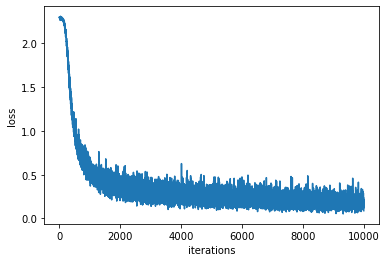

In [15]:
# ch04/train_neuralnet.py
import numpy as np
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
import matplotlib.pyplot as plt

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

# 超参数
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 获取mini-batch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 计算梯度
    grad = network.gradient(x_batch, t_batch)

    # 更新参数（随机梯度下降法，SGD）
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 记录学习过程
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

# 画图
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.show()

由图可知，损失函数在逐渐减小，学习在不断进行！

## 4.5.3 基于测试数据的评价

每经过一个epoch，记录训练数据和测试数据的识别精度

train acc, test acc | 0.09915, 0.1009
train acc, test acc | 0.7920333333333334, 0.7953
train acc, test acc | 0.8775833333333334, 0.8808
train acc, test acc | 0.89885, 0.9017
train acc, test acc | 0.9079333333333334, 0.9095
train acc, test acc | 0.9147333333333333, 0.9151
train acc, test acc | 0.9195833333333333, 0.9196
train acc, test acc | 0.9242166666666667, 0.9253
train acc, test acc | 0.9266166666666666, 0.9267
train acc, test acc | 0.9314333333333333, 0.9314
train acc, test acc | 0.9339166666666666, 0.9358
train acc, test acc | 0.93645, 0.9376
train acc, test acc | 0.93835, 0.938
train acc, test acc | 0.9409833333333333, 0.9408
train acc, test acc | 0.94355, 0.9426
train acc, test acc | 0.94535, 0.9438
train acc, test acc | 0.94685, 0.9461


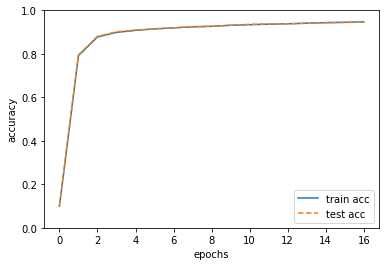

In [17]:
# ch04/train_neuralnet.py
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
# 超参数
iters_num = 10000  
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

# 记录训练过程
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 平均每个epoch的重复次数（所有数据被使用一遍的重复SGD的次数）
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 获取mini-batch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 计算梯度
    grad = network.gradient(x_batch, t_batch)
    
    # 更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 计算每个epoch的识别精度
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 绘制图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()